# Handwritten Letters Autoencoder

In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input

I use grayscale images because letters can be recognized in black and white.

In [12]:
batch_size = 32
IMG_SIZE = 32
CHANNELS = 1
color_mode = 'grayscale' if CHANNELS == 1 else 'rgb'

## Import the Data

In [13]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   validation_split = 0.1,
                                   horizontal_flip=False,
                                   dtype='float16')
train_generator = train_datagen.flow_from_directory(
            '/kaggle/input/classification-of-handwritten-letters/',
            target_size=(IMG_SIZE,IMG_SIZE),
            color_mode=color_mode,
            batch_size=batch_size,
            class_mode='input',
            shuffle=True,
            subset='training',
            seed = 1)
val_generator = train_datagen.flow_from_directory(
            '/kaggle/input/classification-of-handwritten-letters/',
            target_size=(IMG_SIZE,IMG_SIZE),
            color_mode=color_mode,
            batch_size=batch_size,
            class_mode='input',
            shuffle=True,
            subset='validation',
            seed = 1)

Found 31105 images belonging to 4 classes.
Found 3456 images belonging to 4 classes.


In [14]:
from tensorflow.keras.layers import Input, Reshape, Dense, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

## Build the model

The number of dimensions of the compressed image is 40. The original dimension of the image is 32x32 = 1024. That's a 25-fold compression !

In [15]:
dim = 40
interdim = 120

The layers are shared between the model to be trained, the model that generates the compression and the model that decompresses the images.

In [16]:

c2D_1 = Conv2D(32, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same')
c2D_2 = Conv2D(64, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same')
c2D_3 = Conv2D(128, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same')
dense1 = Dense(interdim, activation='relu')
dense2 = Dense(dim, activation='tanh')

dense2t = Dense(interdim, activation='relu')
dense1t = Dense(2048, activation='relu')
c2Dt_3 = Conv2DTranspose(128, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same')
c2Dt_2 = Conv2DTranspose(64, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same')
c2Dt_1 = Conv2DTranspose(32, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same')

c2Dout = Conv2D(CHANNELS, kernel_size=(3, 3), activation='tanh', padding='same')

In [17]:
X_in = Input(shape = (IMG_SIZE,IMG_SIZE,CHANNELS))
X = c2D_1(X_in)
X = MaxPooling2D(pool_size=(2, 2))(X)
print(X.shape)
X = c2D_2(X)
print(X.shape)
X = MaxPooling2D(pool_size=(2, 2))(X)
X = c2D_3(X)
print(X.shape)
X = MaxPooling2D(pool_size=(2, 2))(X)
print(X.shape)
X = Reshape((2048,))(X)
print(X.shape)
X = dense1(X)
X_inter = dense2(X)


X = dense2t(X_inter)
X = dense1t(X)
X = Reshape((4,4,128))(X)
print(X.shape)
X = UpSampling2D((2, 2))(X)
print(X.shape)
X = c2Dt_3(X)
print(X.shape)
X = UpSampling2D((2, 2))(X)
print(X.shape)
X = c2Dt_2(X)
print(X.shape)
X = UpSampling2D((2, 2))(X)
print(X.shape)
X = c2Dt_1(X)

X_out = c2Dout(X)
print(X_out.shape)

model2=Model(inputs=X_in,outputs=X_out)
#model2end = Model(inputs=X_in,outputs=X_out)
model2.compile(optimizer='adam',
                   loss='mse',
                   metrics=['mse'])

model2.summary()

(None, 16, 16, 32)
(None, 16, 16, 64)
(None, 8, 8, 128)
(None, 4, 4, 128)
(None, 2048)
(None, 4, 4, 128)
(None, 8, 8, 128)
(None, 8, 8, 128)
(None, 16, 16, 128)
(None, 16, 16, 64)
(None, 32, 32, 64)
(None, 32, 32, 1)
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
___________________________________

In [18]:
X_in = Input(shape=(dim,))
X = dense2t(X_in)
X = dense1t(X)
X = Reshape((4,4,128))(X)
X = UpSampling2D((2, 2))(X)
X = c2Dt_3(X)
X = UpSampling2D((2, 2))(X)
X = c2Dt_2(X)
X = UpSampling2D((2, 2))(X)
X = c2Dt_1(X)

X_out = c2Dout(X)

model2end=Model(inputs=X_in,outputs=X_out)
model2end.compile(optimizer='adam',
                   loss='mse',
                   metrics=['mse'])

X_in = Input(shape = (IMG_SIZE,IMG_SIZE,CHANNELS))
X = c2D_1(X_in)
X = MaxPooling2D(pool_size=(2, 2))(X)
X = c2D_2(X)
X = MaxPooling2D(pool_size=(2, 2))(X)
X = c2D_3(X)
X = MaxPooling2D(pool_size=(2, 2))(X)
X = Reshape((2048,))(X)
X = dense1(X)
X_out = dense2(X)

model2start=Model(inputs=X_in,outputs=X_out)
model2start.compile(optimizer='adam',
                   loss='mse',
                   metrics=['mse'])

## Training

In [19]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

learning_rate_fn = ExponentialDecay(0.004, 3000, 0.5)

model2.compile(optimizer=Adam(learning_rate=learning_rate_fn),
                   loss='mse',
                   metrics=['mse'])

In [20]:
epochs = 18

step_size_train=train_generator.n//train_generator.batch_size
step_size_val=val_generator.n//val_generator.batch_size

history = model2.fit(train_generator,
                     steps_per_epoch = step_size_train,
                     validation_data = val_generator, 
                     validation_steps = step_size_val,
                     epochs=epochs) 

Epoch 1/18
972/972 [==============================] - 166s 171ms/step - loss: 0.0125 - mse: 0.0125 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 2/18
972/972 [==============================] - 32s 33ms/step - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 3/18
972/972 [==============================] - 32s 33ms/step - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0053 - val_mse: 0.0053
Epoch 4/18
972/972 [==============================] - 31s 32ms/step - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 5/18
972/972 [==============================] - 31s 32ms/step - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 6/18
972/972 [==============================] - 31s 32ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 7/18
972/972 [==============================] - 32s 32ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 8/18
972/972 [==============================] - 31s 32

## Fidelity of the restitution

In [21]:
import matplotlib.pyplot as plt

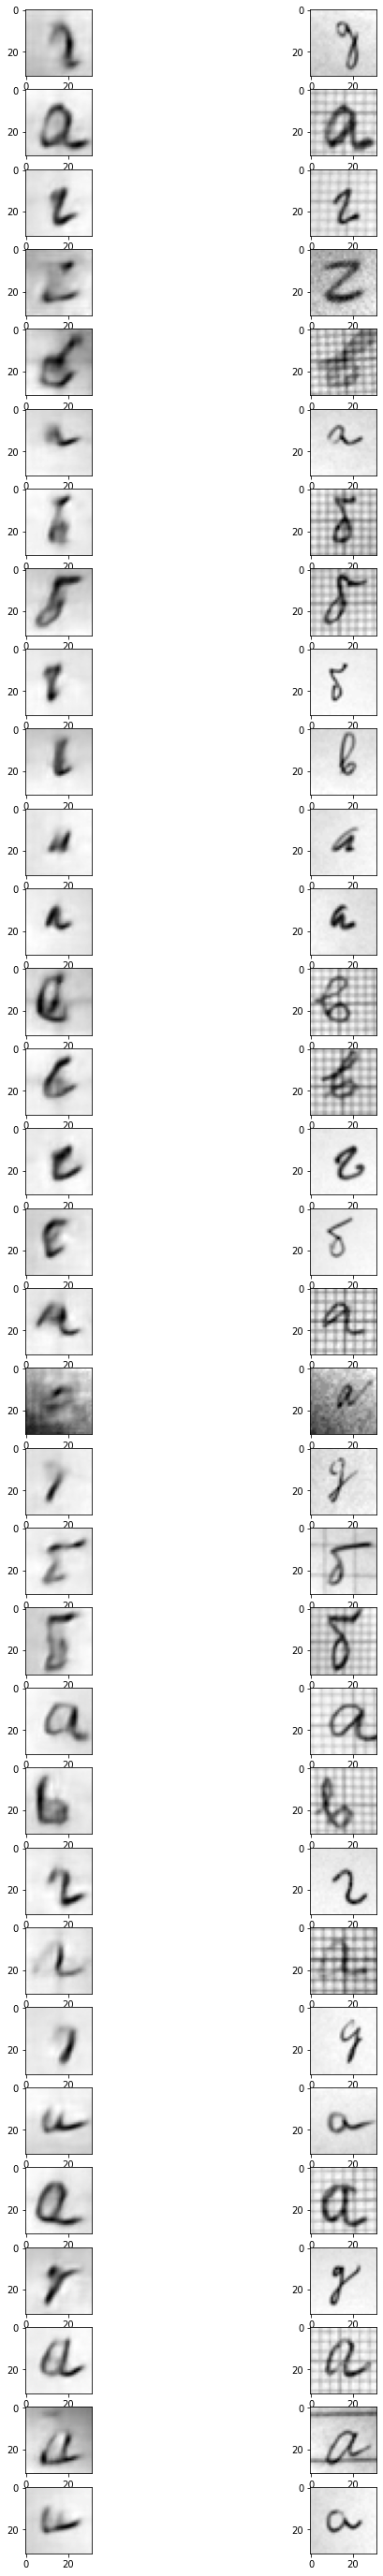

In [22]:
val_generator.reset()
tr,_ = val_generator.next()
r = model2.predict(tr, 1)
fig, axs = plt.subplots(batch_size, 2, figsize=(10,50))
for i in range(batch_size):
    if CHANNELS == 1:
        axs[i,0].imshow(r[i,:,:,0],cmap='gray')
        axs[i,1].imshow(tr[i,:,:,0],cmap='gray')
    else:
        axs[i,0].imshow(r[i,:,:,:])
        axs[i,1].imshow(tr[i,:,:,:])
plt.show()

Images in the left column are the compressed version of the images on the right. The quality of the restitution is ok, but not great. It can be noted that the grid in some of the images disappears. That compression is a way of removing the grid !

## Is the compression maxed out ?

Not completly : when taking random 40D-vectors then decompressing them, we do not get letters. That said, images are not that far from what we could get if we "mixed" handwritten letters. So the limit is probably not that far.

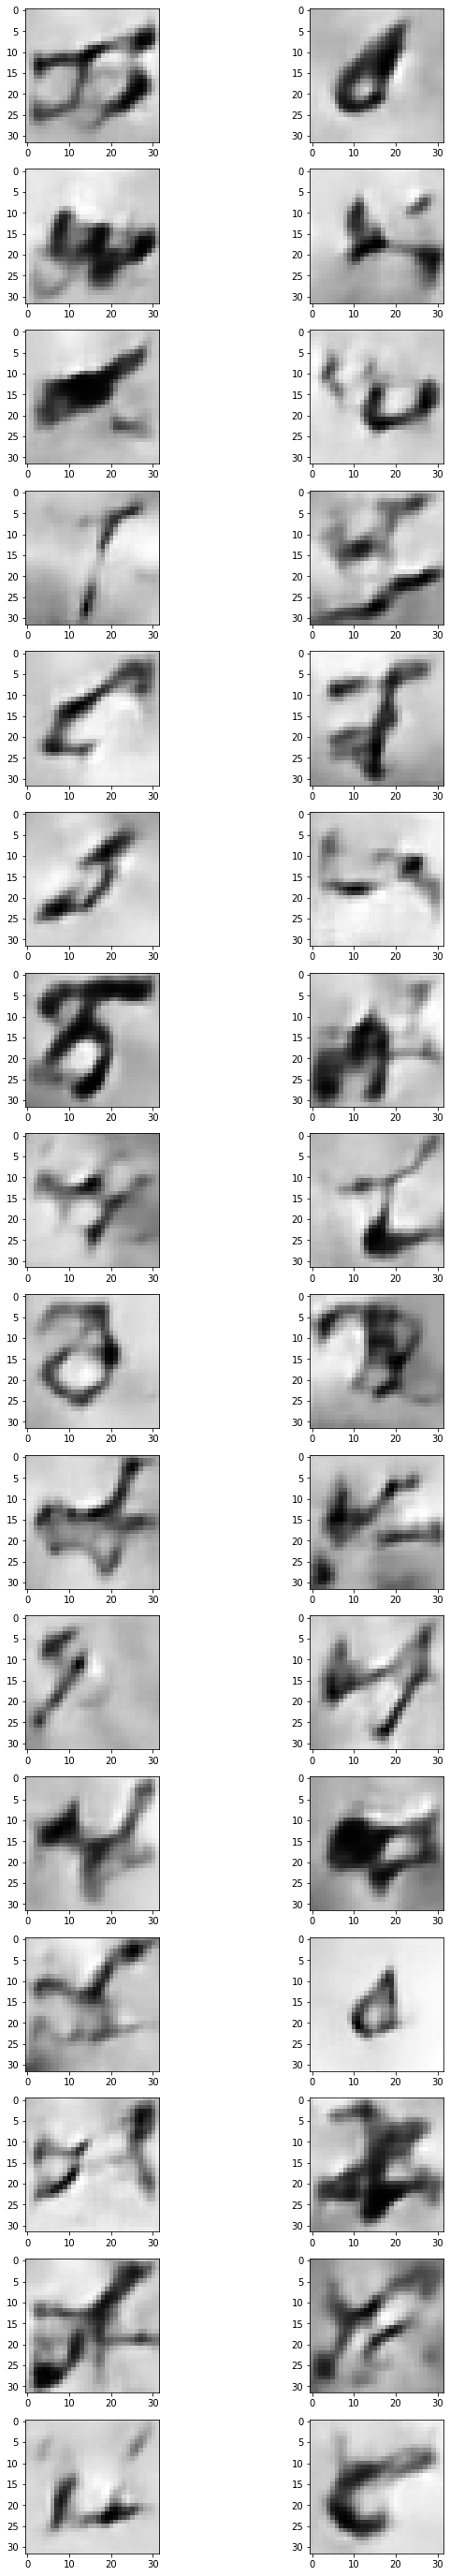

In [23]:
x = np.random.random((batch_size,dim))*2-1
r = model2end.predict(x)
fig, axs = plt.subplots(batch_size//2, 2, figsize=(10,50))
for i in range(batch_size//2):
    if CHANNELS == 1:
        axs[i,0].imshow(r[i*2,:,:,0],cmap='gray')
        axs[i,1].imshow(r[i*2+1,:,:,0],cmap='gray')
    else:
        axs[i,0].imshow(r[i*2,:,:,:])
        axs[i,1].imshow(r[i*2+1,:,:,:])
plt.show()

In [24]:
model2.save('/kaggle/working/gmodel2.tf')
model2end.save('/kaggle/working/gmodel2end.tf')
model2start.save('/kaggle/working/gmodel2start.tf')

In [25]:
from tensorflow.keras.models import load_model

model2 = load_model('/kaggle/working/gmodel2.tf')
model2end = load_model('/kaggle/working/gmodel2end.tf')
model2start = load_model('/kaggle/working/gmodel2start.tf')

## Interpolation between letters

If the compression is good enough, I expect to get believable letters if I take the barycenter between the 40D representation of letters which exist in the dataset. That is what I get, with the limitation that the compressed images are not that close to the "true" images found in the four corners.

In [26]:
val_generator.reset()
val_generator.next()
start,_ = val_generator.next()
end,_ = val_generator.next()
down,_ = val_generator.next()
right,_ = val_generator.next()

In [27]:
startinner = model2start.predict(start[0:1,:,:,:])
endinner = model2start.predict(end[0:1,:,:,:])
downinner = model2start.predict(down[0:1,:,:,:])
rightinner = model2start.predict(right[0:1,:,:,:])

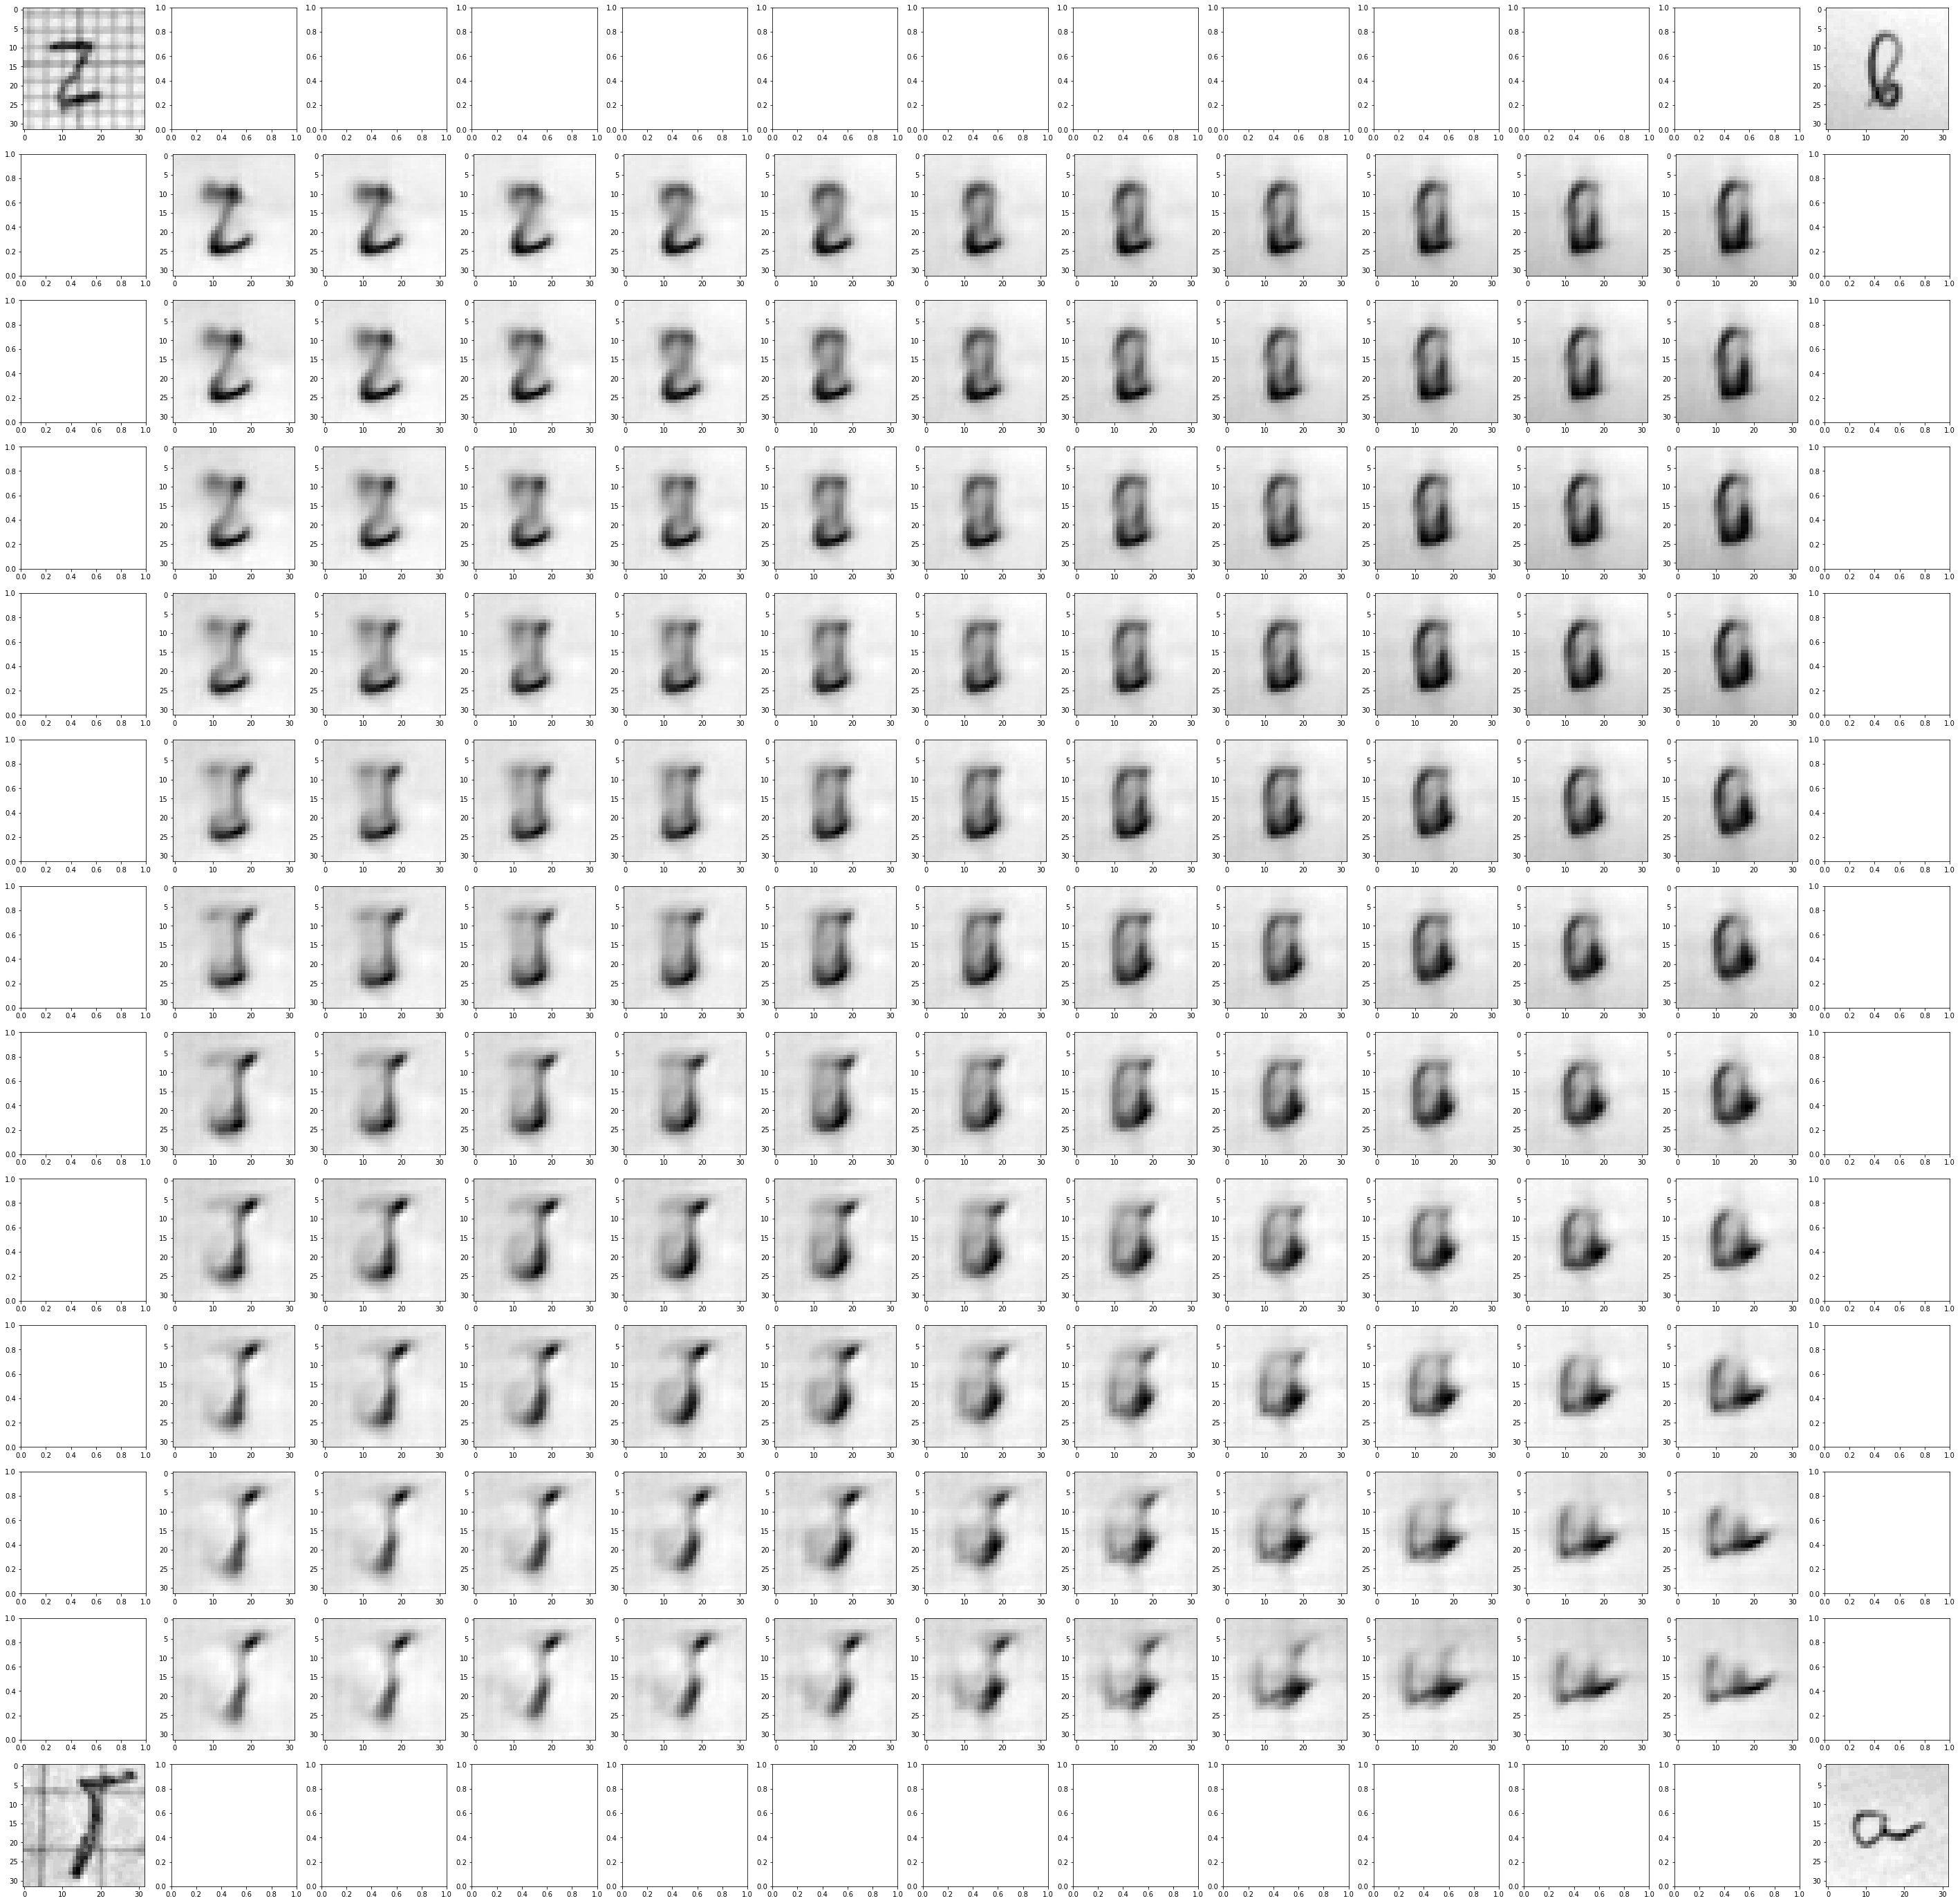

In [28]:
k = 10
fig, axs = plt.subplots(k+3,k+3, figsize=(50,50))
if CHANNELS == 1:
    #axs[0].imshow(end[0,:,:,0],cmap='gray')
    axs[0,0].imshow(start[0,:,:,0],cmap='gray')
    axs[-1,0].imshow(end[0,:,:,0],cmap='gray')
    axs[0,-1].imshow(down[0,:,:,0],cmap='gray')
    axs[-1,-1].imshow(right[0,:,:,0],cmap='gray')

for i in range(k+1):
    for j in range(k+1):
        intermediate_inner1 = (startinner * (k-i) + endinner * i)/k
        intermediate_inner2 = (downinner * (k-i) + rightinner * i)/k
        intermediate_inner = (intermediate_inner1 * (k-j) + intermediate_inner2 * j)/k
        r = model2end.predict(intermediate_inner)
        if CHANNELS == 1:
            axs[i+1,j+1].imshow(r[0,:,:,0],cmap='gray')
        else:
            axs[i+1,j+1].imshow(r[0,:,:,:])
plt.show()